# Practical Session 5 - Parallel Markov chains with multiprocessing and dask

Students (pair):
- [Jérémy Jean](https://github.com/heez77)
- [Maxime Gey](https://github.com/Purjack)


**Useful references for this lab**:

[1] `seaborn`: [official tutorial](https://seaborn.pydata.org/tutorial.html)

[2] `multiprocessing`: [documentation](https://docs.python.org/3/library/multiprocessing.html), [doc2](https://he-arc.github.io/livre-python/multiprocessing/index.html)

[3] `dask`: [documentation](http://numba.pydata.org/) 

## <a name="content">Contents</a>
- [Exercise 1: seaborn, a useful tool for data visualisation](#ex1)
- [Exercise 2: Simulating a discrete-time homogeneous Markov chain](#ex2)
- [Bonus: Parallel computing with Dask](#bonus)
---

In [1]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: seaborn, a useful tool for data visualisation</a> [(&#8593;)](#content)
 
The `seaborn` package can significantly enhance data and data analysis visualization. See the [tutorial page](https://seaborn.pydata.org/tutorial.html) for examples of effective predefined graphics. An example aimed at visualizing the empirical distributions of 9 realizations of a bivariate Gaussian random vector is reported below.

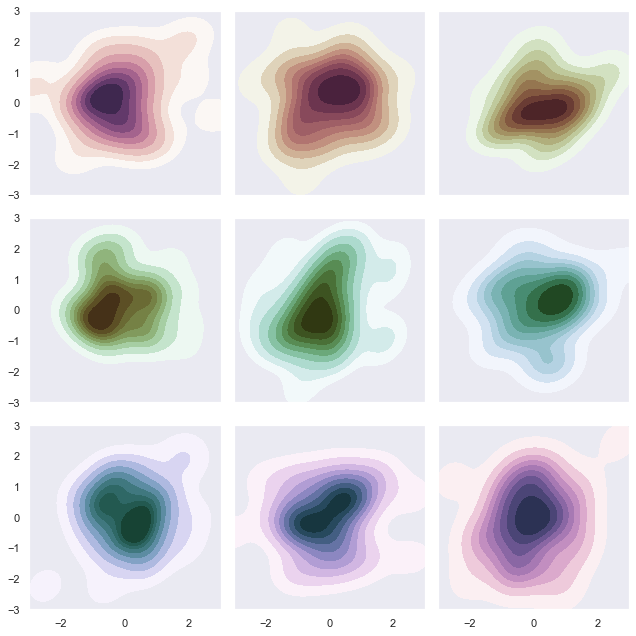

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="dark")
rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50))
    sns.kdeplot(x=x, y=y, cmap=cmap, fill=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

1. Comment on the lines of codes related to the `seaborn` library to make their role explicit. More specifically comment on the KDE method.

**Answer:**

- The set method is an alias for the set_theme method which set aspects of the visual theme for all matplotlib and seaborn plots
- The cubehelix_palette method makes a sequential palette from the cubehelix system. This function produces a colormap with linearly-decreasing (or increasing) brightness. That means that information will be preserved if printed to black and white or viewed by someone who is colorblind. “cubehelix” is also available as a matplotlib-based palette, but this function gives the user more control over the look of the palette and has a different set of defaults.
- The kdeplot method plots univariate or bivariate distributions using kernel density estimation. A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions. Relative to a histogram, KDE can produce a plot that is less cluttered and more interpretable, especially when drawing multiple distributions. But it has the potential to introduce distortions if the underlying distribution is bounded or not smooth. Like a histogram, the quality of the representation also depends on the selection of good smoothing parameters.

2. For one of the realizations, take a look at the documentation of [`sns.jointplot`](https://seaborn.pydata.org/examples/joint_kde.html) to display both the 2-D empirical distribution of the data, and 1D histograms of their distribution along each axis. 

**Answer:**

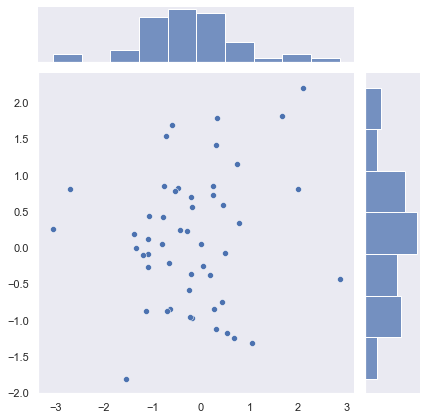

In [21]:
sns.set(style="dark")
rng = np.random.default_rng(50)

cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)
# Generate and plot a random bivariate dataset
x, y = rng.normal(size=(2, 50))
sns.jointplot(x=x, y=y, cmap=cmap)

## <a name="ex2">Exercise 2: Simulating a discrete-time homogeneous Markov chain.</a> [(&#8593;)](#content)


Let ${(X_n)}_{n\geq 0}$ be a discrete-time homogeneous Markov chain with values over a finite ensemble $E=\{x_1,\dots,x_N\}$ identified to $\{1,\dots,N\}$. Consider $\boldsymbol{\rho} \in \Delta_N$, where $\Delta_N = \{\mathbf{x}\in\mathbb{R}^N \mid x_n \geq 0 \, \forall n \in \{1,\dotsc,N\} \text{ and } \sum_n x_n = 1 \}$ is the unit simplex in $\mathbb{R}^N$.

In the following, we consider the initial state of the chain $X_0$, following the discrete probability distribution:

$$
    \mathbb{P}(X_0 = k) = \rho_k, \qquad k \in \{1, \dots,  N\}.
$$
  
Let $\mathbf{A} = [a_{i,j}]_{i,j} \in \mathbb{R}^{N \times N}$ be the transition matrix of the chain, i.e.,

\begin{align*}
    &a_{i,j} = \mathbb{P}(X_{n+1} = j \mid X_{n} = i) \geq 0, \, \forall n \geq 0, \\
    &(\forall i \in \{1, \dotsc, N\}), \quad \sum_{j=1}^N a_{i,j} = 1.
\end{align*}
 
The chain is said to be homogeneous in that $\mathbf{A}$ does not depend from the time index $n$. Let $\tilde{a}_n$ represent the $n^{th}$ row of $\mathbf{A}$. 

The trajectory of the chain can be simulated as follows:

>- Draw the discrete random variable $X_0$ with distribution $\boldsymbol{\rho}$;
>
>- For $q = 0$ to $n_{\text{iter}}-1$
>    - Draw the discrete random variable $X_{q+1}$ with distribution $\tilde{a}_{X_{q}}$;
>    
>- Return ${(X_q)}_{0 \leq q \leq n_{\text{iter}}}$.


<!-- If $X_n = k$, we know that $T$, the life time of the chain in the state $k$ obeys a geometric distribution with parameter $a_{kk}$. We also know that the probability of transition from k to $\ell\neq k$ is given by:

$$
    \mathbb{P}(X_{n+1}=\ell | X_n=k, \ell\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

 ### One possible algorithm to simulate a Markov chain is therefore:

    a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.

    b. at instant $n$, knowing that $X_n=k$,

    i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.

    ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition. -->

1. Implement the above algorithm in a function `X = markov(rho,A,nmax,rng)` with:
     - `rho`: law of the initial state (nonnegative vector of size $N$, summing to 1),
     - `A`: transition matrix (of size $N\times N$),
     - `nmax`: number of time steps,
     - `rng`: random number generator
     - `X`: trajectory of the chain.
     
In particular, check the input parameters `A` and `rho` make sense by adding appropriate assertions (or raising exceptions).

> Hint: the function `np.random.choice` can be useful to draw discrete random variables.

**Answer:**

In [4]:
def markov(rho, A, nmax, rng):
    """Computes a Markov chain based on a transition matrix and initial conditions

    Args:
        rho (np.ndarray): Law of the initial state (nonnegative vector of size N, summing to 1)
        A (np.ndarray): Transition matrix (squared)
        nmax (int): Number of time steps
        rng (np.random._generator.Generator): Random generator

    Returns:
        X: Trajectory of the chain
    """

    assert abs(np.sum(rho)-1.)<=1e-9, "summing of rho composants must be equals to 1"
    assert False not in list(np.abs(np.sum(A, axis=1) - np.full(A.shape[0], 1.))<= np.full(A.shape[0], 1e-9)), "summing of each row of A must be equals to 1"
    assert A.shape[0] == N and A.shape[1] == N, "The transition matrix must be squared"
    for _ in rho:
        assert _ >= 0, "rho must be a nonnegative vector"
    
    X = [rho]
    N = rho.shape[0]
    niter = 0

    nb_points = 1000
    values = np.linspace(1, N, num=N, dtype=int)

    while niter < nmax :
        niter+=1
        rho = rho.T @ A
        X.append(rho)

    return X
        

2. Set the random number generator to a known state. Make a few simulations using simple transition matrices (*i.e.*, taking any nonnegative matrix $A=(a_{i,j})$ such that its lines sum to 1) and display the trajectory of the chains.

**Answer:**

In [5]:
N = 5
rho = np.array([0.05, 0.2, 0.5, 0.2, 0.05])
A = np.array([[0.1, 0.2, 0.6, 0.05, 0.05],
              [0.2, 0.6, 0.05, 0.05, 0.1],
              [0.6, 0.05, 0.05, 0.1, 0.2],
              [0.05, 0.1, 0.2, 0.6, 0.05],
              [0.1, 0.2, 0.6, 0.05, 0.05]])

In [6]:
m = markov(rho, A=A, nmax=10, rng=rng)

3. Explore the potential of the [`multiprocessing` package](https://docs.python.org/3/library/multiprocessing.html) to simulate several Markov chains in parallel.

> Hint: the `mutiprocessing.Pool.starmap` or `mutiprocessing.Pool.starmap_async` methods could be useful.

**Answer:**

In [7]:
from multiprocessing import Pool
from functions import markov

rho0_0 = np.array([0.05, 0.2, 0.5, 0.2, 0.05])
rho0_1 = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
rho0_2 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
rho0_3 = np.array([0.3, 0.4, 0.1, 0.1, 0.1])
rho0_4 = np.array([0.1, 0.3, 0.2, 0.3, 0.1])

A = np.array([[0.1, 0.2, 0.6, 0.05, 0.05],
              [0.2, 0.6, 0.05, 0.05, 0.1],
              [0.6, 0.05, 0.05, 0.1, 0.2],
              [0.05, 0.1, 0.2, 0.6, 0.05],
              [0.1, 0.2, 0.6, 0.05, 0.05]])
nmax = 10
rho0 = [rho0_0, rho0_1, rho0_2, rho0_3, rho0_4]


with Pool(5) as p:
    print(p.starmap(markov, [(rho0[i], A, nmax, rng) for i in range(5)]))

[[array([0.05, 0.2 , 0.5 , 0.2 , 0.05]), array([0.36 , 0.185, 0.135, 0.185, 0.135]), array([0.17675, 0.23525, 0.35   , 0.1585 , 0.0795 ]), array([0.2906   , 0.22575  , 0.2147125, 0.154675 , 0.1142625]), array([0.2221975 , 0.24262562, 0.29587562, 0.14580688, 0.09349438]), array([0.26491003, 0.23808822, 0.24550156, 0.14498756, 0.10651262]), array([0.23931023, 0.2439113 , 0.2760306 , 0.14201824, 0.09872965]), array([0.25530552, 0.24195811, 0.25722466, 0.14191156, 0.10360015]), array([0.24571256, 0.24400839, 0.26868485, 0.14091259, 0.1006816 ]), array([0.25169764, 0.24320937, 0.26165368, 0.14093617, 0.10250315]), array([0.24810097, 0.24394208, 0.26595086, 0.14059758, 0.10140852])], [array([0.1, 0.2, 0.4, 0.2, 0.1]), array([0.31, 0.2 , 0.19, 0.18, 0.12]), array([0.206 , 0.2335, 0.3135, 0.1585, 0.0885]), array([0.272175, 0.230525, 0.23575 , 0.15285 , 0.1087  ]), array([0.233285  , 0.2415625 , 0.28240875, 0.145855  , 0.09688875]), array([0.25806788, 0.23967819, 0.25347381, 0.14434069, 0.10443

4. [Bonus] Generate Markov chains in parallel with the [`dask`](https://docs.dask.org/en/latest/futures.html) library, which offers more general parallelization functionalities (with, for instance, the use of [`Futures`](https://docs.dask.org/en/stable/futures.html), see tutorial [here](https://tutorial.dask.org/05_futures.html)). A useful example is provided [here](https://stackoverflow.com/questions/41471248/how-to-efficiently-submit-tasks-with-large-arguments-in-dask-distributed). Note that `dask` is much more versatile and powerful than `multiprocessing`, and can be useful to scale algorithms over multiple cores and/or computing nodes.

**Answer:**

In [19]:
from dask.distributed import Client
from functions import markov

client = Client()
for i in range(N):
    print(client.submit(markov, rho0[i], A, nmax, rng).result())

c:\Users\geyma\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58271 instead
  warnings.warn(


[array([0.05, 0.2 , 0.5 , 0.2 , 0.05]), array([0.36 , 0.185, 0.135, 0.185, 0.135]), array([0.17675, 0.23525, 0.35   , 0.1585 , 0.0795 ]), array([0.2906   , 0.22575  , 0.2147125, 0.154675 , 0.1142625]), array([0.2221975 , 0.24262562, 0.29587562, 0.14580688, 0.09349438]), array([0.26491003, 0.23808822, 0.24550156, 0.14498756, 0.10651262]), array([0.23931023, 0.2439113 , 0.2760306 , 0.14201824, 0.09872965]), array([0.25530552, 0.24195811, 0.25722466, 0.14191156, 0.10360015]), array([0.24571256, 0.24400839, 0.26868485, 0.14091259, 0.1006816 ]), array([0.25169764, 0.24320937, 0.26165368, 0.14093617, 0.10250315]), array([0.24810097, 0.24394208, 0.26595086, 0.14059758, 0.10140852])]
[array([0.1, 0.2, 0.4, 0.2, 0.1]), array([0.31, 0.2 , 0.19, 0.18, 0.12]), array([0.206 , 0.2335, 0.3135, 0.1585, 0.0885]), array([0.272175, 0.230525, 0.23575 , 0.15285 , 0.1087  ]), array([0.233285  , 0.2415625 , 0.28240875, 0.145855  , 0.09688875]), array([0.25806788, 0.23967819, 0.25347381, 0.14434069, 0.1044394

## <a name="bonus">Bonus: Parallel computing with Dask</a> [(&#8593;)](#content)

1. Take a look at the [`dask.array` documentation](https://docs.dask.org/en/stable/array-best-practices.html) and the associate [tutorial](https://tutorial.dask.org/02_array.html). Apply some of the functions introduced herein and in the [documentation](https://docs.dask.org/en/stable/array-best-practices.html) to parallelize the computation of the total variation investigated during session 2. Note that you can combine `dask` and `numba` to obtain an overall more efficient implementation. Note that timing can be worse than Numpy (`dask.array` is more specifically interesting when the data do no fit in memory).

2. Take a look at the [`dask.delayed` tutorial](https://tutorial.dask.org/03_dask.delayed.html), and go through some of the examples provided. [Best practices with the `dask.delayed` interface](https://docs.dask.org/en/stable/delayed-best-practices.html) are summarized in the documentation.

> **Remark**: an alternative to Dask: the [Ray](https://docs.ray.io/en/latest/) library.

**Answer:**

In [11]:
# your code